In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
# From: 
# https://github.com/lucko515/tesla-stocks-prediction/blob/master/tensorflow_lstm.ipynb

In [4]:
from google.colab import drive
drive.mount('/content/drive') 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
_TESLA_DATA_PATH="drive/My Drive/AIclass/L7_Tesla_stock.txt" 

In [11]:
tesla_stocks = pd.read_csv(_TESLA_DATA_PATH, sep='\t') # do not use old read_table
tesla_stocks.head()


,date,close,volume,open,high,low
0,15/10/15,221.31,2835920,216.43,221.7300,213.70
1,16/10/15,227.01,4327574,223.04,230.4805,222.87
2,19/10/15,228.10,2506836,226.50,231.1500,224.94
3,20/10/15,213.03,14877020,227.72,228.6000,202.00
4,21/10/15,210.09,4177956,211.99,214.8100,208.80


In [0]:
# We have a different file format:
# Date	Open	High	Low	Close	Volume

In [12]:
data_to_use = tesla_stocks['close'].values
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 757


In [17]:
# Scale the data - usually we will work on [0 1] or here [-1 1] scale
scaler = StandardScaler()

scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))
scaled_dataset[1:10,]

array([[-0.78223524],
       [-0.76355167],
       [-1.02186495],
       [-1.07225917],
       [-1.04431952],
       [-1.08940007],
       [-0.98364075],
       [-1.06780254],
       [-1.02306481]])

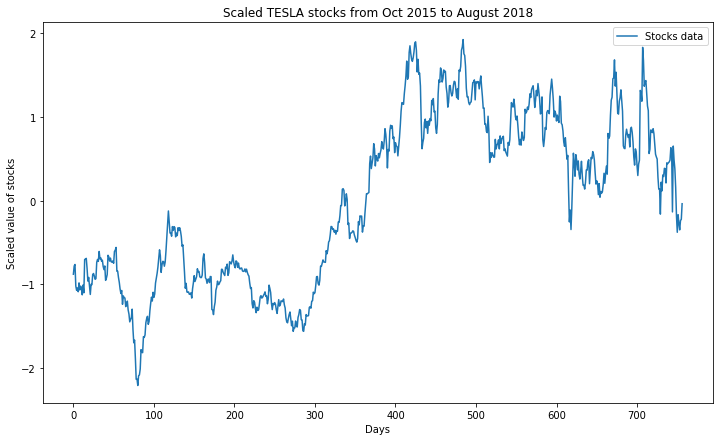

In [18]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from Oct 2015 to August 2018')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [0]:
# Break down data into small subsets and a 2nd vector of the next 
# (to be predicted) values
# [1,2,3,4,5,6,7,8,9]
# XX = [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]
# yy = [4, 5, 6, 7, 8, 9]

def window_data(data, window_size):
    XX = []
    yy = []
    
    ii = 0
    while (ii + window_size) <= len(data) - 1:
        XX.append(data[ii:ii+window_size]) # takes 1st ii:ii+window_size elements 
        yy.append(data[ii+window_size]) # takes the next element after the above
        ii += 1
    assert len(XX) ==  len(yy)
    return XX, yy

In [0]:
XX, yy = window_data(scaled_dataset, 7)

In [0]:
# Set up the RNN
epochs = 200
batch_size = 7

In [0]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)     
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

In [0]:
def output_layer(lstm_output, in_size, out_size):
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    output = tf.matmul(x, weights) + bias
    return output

In [0]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])    
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    # Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [0]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, 
                 number_of_layers=1, dropout=True, dropout_rate=0.8, 
                 number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], 
                                     name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size,1],name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, 
                                     number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, 
                                            initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size,number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, 
                                       gradient_clip_margin)

In [42]:
tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [53]:
# separate data into training and testing
print(len(XX))
XX_train = XX[0:600]
yy_train = yy[0:600]

XX_test = XX[600:len(XX)]
print(len(XX_test))
yy_test = yy[600:len(yy)]

750
150


In [54]:
# Train the network
session =  tf.Session()
session.run(tf.global_variables_initializer())

for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    #while(ii + batch_size) <= len(X_train):
    while(ii + batch_size) <= len(XX_train):
        X_batch = XX_train[ii:ii+batch_size]
        y_batch = yy_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], 
                              feed_dict={model.inputs:X_batch,model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.05235296115279198
Epoch 30/200  Current loss: 0.00875425711274147
Epoch 60/200  Current loss: 0.008119474165141582
Epoch 90/200  Current loss: 0.00805274024605751
Epoch 120/200  Current loss: 0.00731243472546339
Epoch 150/200  Current loss: 0.007010159082710743
Epoch 180/200  Current loss: 0.00662501435726881


In [0]:
sup =[]
for ii in range(len(traind_scores)):
    for jj in range(len(traind_scores[ii])):
        sup.append(traind_scores[ii][jj])

In [0]:
tests = []
ii = 0
while ii+batch_size <= len(XX_test): 
    oo = session.run([model.logits], feed_dict={model.inputs:XX_test[ii:ii+batch_size]})
    ii += batch_size
    tests.append(oo)
    

In [65]:
len(tests)

21

In [0]:
tests_new = []
for ii in range(len(tests)):
    for jj in range(len(tests[ii][0])):
        tests_new.append(tests[ii][0][jj])

In [68]:
len(tests_new)

147

85

In [0]:
# make a new array with no values untill the predicted data starts
test_results = []
for ii in range(747):
    if ii >= 601:
        test_results.append(tests_new[ii-601])
    else:
        test_results.append(None)

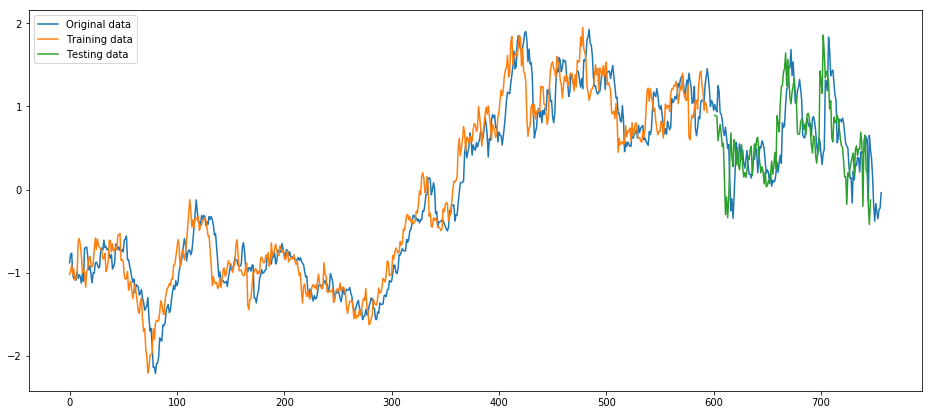

In [77]:
# Plot predictions - green (predicted) are looking well
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()